<a href="https://colab.research.google.com/github/Wyw021214/ISP_autism/blob/main/ABIDE_data_remove_subcortical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ABIDE Dataset - ASD

In [38]:
# Main collect and download function
def collect_and_download(derivative, pipeline, strategy, out_dir, diagnosis):
    import os
    import urllib.request as request

    # Init variables
    mean_fd_thresh = 0.2
    s3_prefix = 'https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative'
    s3_pheno_path = '/'.join([s3_prefix, 'Phenotypic_V1_0b_preprocessed1.csv'])

    derivative = derivative.lower()
    pipeline = pipeline.lower()
    strategy = strategy.lower()

    # Check derivative for extension
    if 'roi' in derivative:
        extension = '.1D'
    else:
        extension = '.nii.gz'

    if not os.path.exists(out_dir):
        print('Could not find {0}, creating now...'.format(out_dir))
        os.makedirs(out_dir)

    s3_pheno_file = request.urlopen(s3_pheno_path)
    pheno_list = s3_pheno_file.readlines()

    header = pheno_list[0].decode().split(',')
    try:
        site_idx = header.index('SITE_ID')
        file_idx = header.index('FILE_ID')
        age_idx = header.index('AGE_AT_SCAN')
        sex_idx = header.index('SEX')
        dx_idx = header.index('DX_GROUP')
        mean_fd_idx = header.index('func_mean_fd')
    except Exception as exc:
        err_msg = 'Unable to extract header information from the pheno file...'
        raise Exception(err_msg)

    s3_paths = []
    for pheno_row in pheno_list[1:]:
        cs_row = pheno_row.decode().split(',')

        try:
            row_file_id = cs_row[file_idx]
            row_site = cs_row[site_idx]
            row_age = float(cs_row[age_idx])
            row_sex = cs_row[sex_idx]
            row_dx = cs_row[dx_idx]
            row_mean_fd = float(cs_row[mean_fd_idx])
        except Exception as e:
            continue

        if row_file_id == 'no_filename':
            continue
        if row_mean_fd >= mean_fd_thresh:
            continue

        if (diagnosis == 'asd' and row_dx != '1') or (diagnosis == 'tdc' and row_dx != '2'):
            continue

        filename = row_file_id + '_' + derivative + extension
        s3_path = '/'.join([s3_prefix, 'Outputs', pipeline, strategy, derivative, filename])
        s3_paths.append(s3_path)

    total_num_files = len(s3_paths)
    for path_idx, s3_path in enumerate(s3_paths):
        rel_path = s3_path.lstrip(s3_prefix)
        download_file = os.path.join(out_dir, rel_path)
        download_dir = os.path.dirname(download_file)
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)
        try:
            if not os.path.exists(download_file):
                print('Retrieving: {0}'.format(download_file))
                request.urlretrieve(s3_path, download_file)
                print('{0:.3f}% percent complete'.format(100*(float(path_idx+1)/total_num_files)))
            else:
                print('File {0} already exists, skipping...'.format(download_file))
        except Exception as exc:
            print('There was a problem downloading {0}.\n Check input arguments and try again.'.format(s3_path))

    print('Done!')

# pipelines = ["ccs", "cpac", "dparsf", "niak"]
# strategies = ["filt_global", "filt_noglobal", "nofilt_global", "nofilt_noglobal"]
# derivatives = ["alff", "degree_binarize", "degree_weighted", "dual_regression", "eigenvector_binarize", "eigenvector_weighted", "falff", "func_mask", "func_mean", "func_preproc", "lfcd", "reho", "rois_aal", "rois_cc200", "rois_cc400", "rois_dosenbach160", "rois_ez", "rois_ho", "rois_tt", "vmhc"]
# extensions = ["1D", "nii.gz"]

# Variables to specify download settings (modify these values as needed)
desired_derivative = 'rois_aal'  # Derivative of interest (e.g. 'reho')
desired_pipeline = 'cpac'     # Pipeline used to preprocess the data (e.g. 'cpac')
desired_strategy = 'filt_global'  # Noise-removal strategy used during preprocessing
download_data_dir = 'preprocessed_dataset'  # Path to local folder to download files to
desired_diagnosis = 'asd'  # 'asd', 'tdc', or 'both' corresponding to the diagnosis of the participants for whom data should be downloaded

# Call the collect and download routine
collect_and_download(desired_derivative, desired_pipeline, desired_strategy, download_data_dir, desired_diagnosis)

File preprocessed_dataset/Outputs/cpac/filt_global/rois_aal/Pitt_0050004_rois_aal.1D already exists, skipping...
File preprocessed_dataset/Outputs/cpac/filt_global/rois_aal/Pitt_0050005_rois_aal.1D already exists, skipping...
File preprocessed_dataset/Outputs/cpac/filt_global/rois_aal/Pitt_0050006_rois_aal.1D already exists, skipping...
File preprocessed_dataset/Outputs/cpac/filt_global/rois_aal/Pitt_0050007_rois_aal.1D already exists, skipping...
File preprocessed_dataset/Outputs/cpac/filt_global/rois_aal/Pitt_0050008_rois_aal.1D already exists, skipping...
File preprocessed_dataset/Outputs/cpac/filt_global/rois_aal/Pitt_0050009_rois_aal.1D already exists, skipping...
File preprocessed_dataset/Outputs/cpac/filt_global/rois_aal/Pitt_0050010_rois_aal.1D already exists, skipping...
File preprocessed_dataset/Outputs/cpac/filt_global/rois_aal/Pitt_0050011_rois_aal.1D already exists, skipping...
File preprocessed_dataset/Outputs/cpac/filt_global/rois_aal/Pitt_0050012_rois_aal.1D already exi

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
download_data_dir = '/content/drive/MyDrive/preprocessed_dataset'

In [41]:
import os
import numpy as np
import pandas as pd

# Directory containing the .1D files (replace with your path)
data_dir = '/content/drive/MyDrive/preprocessed_dataset/'

import glob

# Define the path to the subject data files
data_files = glob.glob('/content/drive/MyDrive/preprocessed_dataset/dataset.zip/Outputs/cpac/filt_global/rois_aal')  # Assuming 1D files for each subject

In [42]:
import numpy as np

# Define the path to a sample subject file (assuming it's the same format for all subjects)
sample_file = '/content/preprocessed_dataset/Outputs/cpac/filt_global/rois_aal/Stanford_0051165_rois_aal.1D'

# Load the data from the file
data = np.loadtxt(sample_file)

# Calculate the number of ROIs and number of time points
num_rois = data.shape[1]  # Number of columns = number of ROIs
num_time_points = data.shape[0]  # Number of rows = number of time points

print(f"Number of ROIs: {num_rois}")
print(f"Number of Time Points: {num_time_points}")
print(data.shape)

Number of ROIs: 116
Number of Time Points: 176
(176, 116)


In [43]:
import numpy as np
import pandas as pd
import glob

data_files = glob.glob('/content/preprocessed_dataset/Outputs/cpac/filt_global/rois_aal/*.1D')

total_rois = 0
total_time_points = 0
num_files = 0

for file in data_files:
    try:
        # Use pandas for flexibility
        data = pd.read_csv(file, delim_whitespace=True, header=None)
        num_time_points, num_rois = data.shape  # Get dimensions

        total_rois += num_rois
        total_time_points += num_time_points
        num_files += 1  # Only count successfully processed files

    except Exception as e:
        print(f"Error loading {file}: {e}")

if num_files > 0:
    average_rois = total_rois / num_files
    average_time_points = total_time_points / num_files
    print(f"Average number of ROIs: {average_rois}")
    print(f"Average number of time points: {average_time_points}")
else:
    print("No valid files processed.")

<ipython-input-43-1e15628032ff>:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file, delim_whitespace=True, header=None)
<ipython-input-43-1e15628032ff>:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file, delim_whitespace=True, header=None)
<ipython-input-43-1e15628032ff>:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file, delim_whitespace=True, header=None)
<ipython-input-43-1e15628032ff>:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file, delim_whitespace=True, header=None)
<ipython-input-43-1e15628032ff>:14: 

Average number of ROIs: 116.0
Average number of time points: 192.5563725490196


<ipython-input-43-1e15628032ff>:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file, delim_whitespace=True, header=None)


In [44]:
import numpy as np
import glob

# Path to your AAL parcellation files (adjust accordingly)
data_files = glob.glob('/content/preprocessed_dataset/Outputs/cpac/filt_global/rois_aal/*.1D')

# Initialize list to store time series lengths
time_lengths = []

for file in data_files:
    try:
        data = np.loadtxt(file)  # Shape: (timepoints × ROIs)
        time_lengths.append(data.shape[0])  # Number of timepoints (rows)
    except Exception as e:
        print(f"Error reading {file}: {e}")

# Check if we have valid entries
if time_lengths:
    min_timepoints = min(time_lengths)
    max_timepoints = max(time_lengths)
    avg_timepoints = sum(time_lengths) / len(time_lengths)

    print(f"Number of valid subjects: {len(time_lengths)}")
    print(f"Shortest time series: {min_timepoints} timepoints")
    print(f"Longest time series: {max_timepoints} timepoints")
    print(f"Average time series length: {avg_timepoints:.2f} timepoints")
else:
    print("No valid files found.")


Number of valid subjects: 408
Shortest time series: 78 timepoints
Longest time series: 316 timepoints
Average time series length: 191.56 timepoints


In [37]:
'''# check subjects with ≥180 timepoints
min_time_thresh = 180
short_enough = [t for t in time_lengths if t >= 180]
print(f"Subjects with ≥180 timepoints: {len(short_enough)} / {len(time_lengths)}")'''

Subjects with ≥180 timepoints: 195 / 408


# Interpolated Time Series to 192 timepoints

In [46]:
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
import glob
import os

input_folder = "/content/preprocessed_dataset/Outputs/cpac/filt_global/rois_aal/"
output_folder = "/content/drive/MyDrive/preprocessed_dataset/interpolated_data_new/"
os.makedirs(output_folder, exist_ok=True)

num_rois = 116  # Expected number of ROIs (columns)
target_timepoints = 192  # Desired number of timepoints (rows)

# Interpolation Function
def interpolate_time_series(data, target_length):
    """
    Interpolate each ROI's time series (column) to a fixed number of timepoints.
    Assumes input data is shape: (timepoints × ROIs)
    """
    original_length = data.shape[0]
    original_time = np.arange(original_length)
    new_time = np.linspace(0, original_length - 1, target_length)

    interpolated_data = np.zeros((target_length, data.shape[1]))

    for roi_idx in range(data.shape[1]):
        f = interp1d(original_time, data[:, roi_idx], kind='linear', fill_value='extrapolate')
        interpolated_data[:, roi_idx] = f(new_time)

    return interpolated_data

# Process All Files
data_files = glob.glob(os.path.join(input_folder, "*.1D"))
num_subjects = len(data_files)

restdata = np.zeros((target_timepoints, num_rois, num_subjects))
skipped_files = []
subject_index = 0

for i, file in enumerate(data_files):
    try:
        # Load data as (timepoints × ROIs)
        subj_data = pd.read_csv(file, delim_whitespace=True, header=None, comment='#').values

        # Check if number of ROIs is correct
        if subj_data.shape[1] != num_rois:
            print(f"Skipping {file} due to ROI mismatch: {subj_data.shape}")
            skipped_files.append(file)
            continue

        # Interpolate
        subj_data_interp = interpolate_time_series(subj_data, target_timepoints)

        # Assign to 3D matrix
        restdata[:, :, subject_index] = subj_data_interp
        subject_index += 1

        # Save subject-level data
        subj_filename = os.path.basename(file).replace(".1D", ".npy")
        np.save(os.path.join(output_folder, subj_filename), subj_data_interp)

    except Exception as e:
        print(f"Error processing {file}: {e}")
        skipped_files.append(file)

# Trim unused slots in restdata
restdata = restdata[:, :, :subject_index]

# Save the full 3D matrix
np.save(os.path.join(output_folder, "restdata.npy"), restdata)

print(f"\n Interpolation complete. Saved {subject_index} subjects.")
if skipped_files:
    print(f" Skipped {len(skipped_files)} files due to issues.")


<ipython-input-46-5aad8104a65f>:43: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  subj_data = pd.read_csv(file, delim_whitespace=True, header=None, comment='#').values
<ipython-input-46-5aad8104a65f>:43: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  subj_data = pd.read_csv(file, delim_whitespace=True, header=None, comment='#').values
<ipython-input-46-5aad8104a65f>:43: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  subj_data = pd.read_csv(file, delim_whitespace=True, header=None, comment='#').values
<ipython-input-46-5aad8104a65f>:43: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  subj_data = pd.read_cs


 Interpolation complete. Saved 408 subjects.


<ipython-input-48-dfae84c47a32>:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True, header=None, comment='#').values


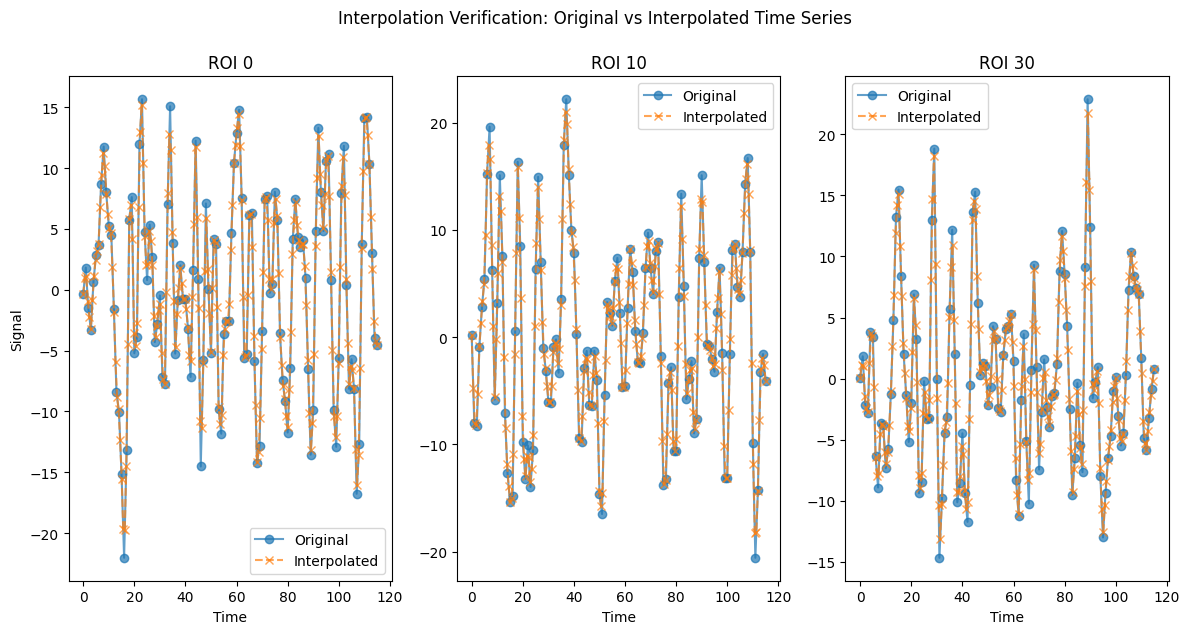

In [48]:
# Verify Interpolated Time Series
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# ===== Configuration =====
file_path = '/content/preprocessed_dataset/Outputs/cpac/filt_global/rois_aal/MaxMun_b_0051326_rois_aal.1D'  # Update to any .1D file
target_timepoints = 192  # Interpolation target
roi_indices_to_plot = [0, 10, 30]  # Pick a few ROIs to visualize

# ===== Load Original Data (Timepoints × ROIs) =====
data = pd.read_csv(file_path, delim_whitespace=True, header=None, comment='#').values
original_time = np.arange(data.shape[0])
interpolated_time = np.linspace(0, data.shape[0] - 1, target_timepoints)

# ===== Interpolate Function =====
def interpolate_time_series(data, target_length):
    original_time = np.arange(data.shape[0])
    new_time = np.linspace(0, data.shape[0] - 1, target_length)
    interpolated_data = np.zeros((target_length, data.shape[1]))
    for roi in range(data.shape[1]):
        f = interp1d(original_time, data[:, roi], kind='linear', fill_value='extrapolate')
        interpolated_data[:, roi] = f(new_time)
    return interpolated_data

# ===== Interpolate the Data =====
interpolated_data = interpolate_time_series(data, target_timepoints)

# ===== Plotting for a Few ROIs =====
plt.figure(figsize=(12, 6))
for i, roi in enumerate(roi_indices_to_plot):
    plt.subplot(1, len(roi_indices_to_plot), i + 1)
    plt.plot(original_time, data[:, roi], 'o-', label='Original', alpha=0.7)
    plt.plot(interpolated_time, interpolated_data[:, roi], 'x--', label='Interpolated', alpha=0.7)
    plt.title(f'ROI {roi}')
    plt.xlabel('Time')
    if i == 0:
        plt.ylabel('Signal')
    plt.legend()
    plt.tight_layout()

plt.suptitle("Interpolation Verification: Original vs Interpolated Time Series", y=1.05)
plt.show()


In [49]:
# Correlation between original and interpolated (downsampled to same length)
from scipy.stats import pearsonr
for roi in roi_indices_to_plot:
    r, _ = pearsonr(np.interp(original_time, interpolated_time, interpolated_data[:, roi]), data[:, roi])
    print(f"ROI {roi} correlation between original and interpolated: r = {r:.4f}")


ROI 0 correlation between original and interpolated: r = 0.9956
ROI 10 correlation between original and interpolated: r = 0.9968
ROI 30 correlation between original and interpolated: r = 0.9953


# Remove Subcortical ROIs

In [50]:
import numpy as np
import os

# Load Interpolated Data
data_path = '/content/drive/MyDrive/preprocessed_dataset/interpolated_data_new/restdata.npy'
restdata = np.load(data_path)  # Shape: (timepoints, 116 ROIs, subjects)

# Define Indices to Keep (Cortical ROIs)
all_indices = np.arange(116)
subcortical_indices = np.arange(70, 116)  # AAL ROIs 71–116 (Python: 70–115)
cortical_indices = np.setdiff1d(all_indices, subcortical_indices)

# Extract Cortical-Only Data
restdata_cortical = restdata[:, cortical_indices, :]

print("Original shape:", restdata.shape)
print("After subcortical removal:", restdata_cortical.shape)

# Save New Data
np.save('/content/drive/MyDrive/preprocessed_dataset/interpolated_data_new/restdata_cortical.npy', restdata_cortical)


Original shape: (192, 116, 408)
After subcortical removal: (192, 70, 408)
